# Imports

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)


import sklearn
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

from xml.etree.ElementTree import fromstring, ElementTree

import utilities

import pandas as pd
import researchpy as rp
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '{:.0f}'.format(x) if abs(x - round(x)) < 1e-6 else '{:,.2f}'.format(x))
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)

country_df = pd.read_csv("country_df.csv")
league_df = pd.read_csv("league_df.csv")

match_df = pd.read_csv("match_df.csv")
match_df["season"] = match_df["season"].apply(lambda x: x[:4])

player_df = pd.read_csv("player_df.csv")
player_attributes_df = pd.read_csv("player_attributes_df.csv")
team_df = pd.read_csv("team_df.csv")
team_attributes_df = pd.read_csv("team_attributes_df.csv")
goal_xml = utilities.extract_xml_details(match_df["goal"])

country_league = pd.merge(right=country_df, left=league_df, right_on='id', left_on='id')[['country_id', 'name_x','name_y']]

use_match = match_df[['league_id', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'season']].fillna(0).astype(int)
use_match["goals"] = use_match["home_team_goal"] + use_match["away_team_goal"]

use_goal = goal_xml[['goals', 'player1', 'team', 'subtype']].copy()
use_goal[['goals', 'player1', 'team']] = use_goal[['goals', 'player1', 'team']].fillna(0).astype(int)

use_team = team_df[['team_api_id', 'team_long_name']].copy()
use_team['team_api_id'] = use_team['team_api_id'].fillna(0).astype(int)

use_player = player_df[['player_api_id', 'player_name', 'player_fifa_api_id']].copy()
use_player[['player_api_id' , 'player_fifa_api_id']] = use_player[['player_api_id' , 'player_fifa_api_id']].fillna(0).astype(int)

games_country = pd.merge(right=use_match, left=country_league, right_on='league_id', left_on='country_id')[['name_x', 'name_y', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']]
players_goal = pd.merge(right=use_match, left=use_goal, right_on='home_team_api_id', left_on='team')
players_goal = players_goal.loc[:,~players_goal.columns.duplicated()]


# Questions

## Which leagues are in which countries?

In [2]:
country_league = pd.merge(right=country_df, left=league_df, right_on='id', left_on='id')[['country_id', 'name_x','name_y']]

country_league[['name_x', 'name_y']]

,name_x,name_y
0,Belgium Jupiler League,Belgium
1,England Premier League,England
2,France Ligue 1,France
3,Germany 1. Bundesliga,Germany
4,Italy Serie A,Italy
5,Netherlands Eredivisie,Netherlands
6,Poland Ekstraklasa,Poland
7,Portugal Liga ZON Sagres,Portugal
8,Scotland Premier League,Scotland
9,Spain LIGA BBVA,Spain


## Which leagues score the most/fewest goals?



In [3]:
question_2 = games_country.groupby(['name_x', 'name_y'])['home_team_goal'].sum().reset_index().sort_values(by='home_team_goal', ascending=False)

question_2.iloc[[0, -1]]

,name_x,name_y,home_team_goal
9,Spain LIGA BBVA,Spain,4959
10,Switzerland Super League,Switzerland,2365


## Who are the top scorers in each team and league?

In [4]:
goals_per_player = use_goal.groupby('player1').sum('goals').sort_values(by='goals', ascending=False)

goals_pp = pd.merge(right=goals_per_player, left=use_player, right_on='player1', left_on='player_api_id').sort_values(by='goals', ascending=False).reset_index( drop=True)[['player_api_id', 'player_name', 'goals', 'team']]
max_goals_indices_per_team = goals_pp.groupby('team')['goals'].idxmax()

highest_scorers_per_team = goals_pp.loc[max_goals_indices_per_team]

highest_scorers_per_team.reset_index(drop=True, inplace=True)

sum_goals_per_player_per_team = highest_scorers_per_team.groupby(['team', 'player_api_id', 'player_name'])['goals'].sum().reset_index()

sum_goals_per_player_per_team.sort_values(by='goals', ascending=False, inplace=True)

sum_goals_per_player_per_team.head()


,team,player_api_id,player_name,goals
2740,2547030,30981,Lionel Messi,253
2739,2536110,30893,Cristiano Ronaldo,230
2738,1929838,35724,Zlatan Ibrahimovic,166
2736,1594050,25759,Gonzalo Higuain,157
2735,1393086,37412,Sergio Aguero,144


## Is there such a thing as home advantage?


/var/folders/k1/1bd5lx_d219gy8hl39z8vwx80000gn/T/ipykernel_13503/3684381822.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  goals_season = use_match.groupby("season")["goals", "away_team_goal", "home_team_goal"].sum().reset_index()


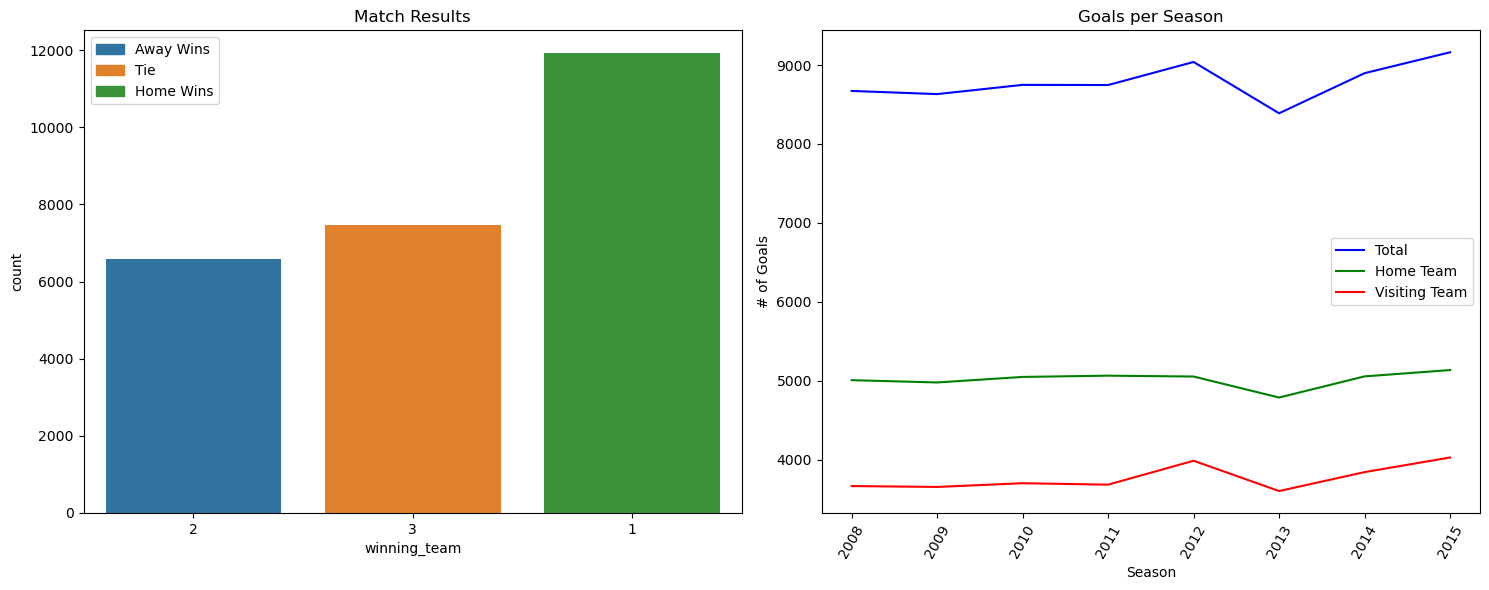

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


goals_season = use_match.groupby("season")["goals", "away_team_goal", "home_team_goal"].sum().reset_index()

match_df["winning_team"] = match_df.apply(utilities.assign_victory, axis = 1)
match_df[["home_team_result", "away_team_result"]] = match_df.apply(utilities.getTeamResult, axis = 1, result_type="expand")

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax1 = sns.countplot(x="winning_team", data=match_df, ax=axs[0])
legend_labels = ['Away Wins', 'Tie', 'Home Wins']
handles = [plt.Rectangle((0,0),1,1, color=ax1.patches[i].get_facecolor()) for i in range(3)]
ax1.legend(handles, legend_labels)
ax1.set_title('Match Results')

ax2 = sns.lineplot(data=goals_season, x="season", y="goals", color='blue', label='Total', ax=axs[1])
sns.lineplot(data=goals_season, x="season", y="home_team_goal", color='green', label='Home Team', ax=ax2)
sns.lineplot(data=goals_season, x="season", y="away_team_goal", color='red', label='Visiting Team', ax=ax2)
ax2.set_ylabel("# of Goals")
ax2.set_xlabel("Season")
ax2.set_title('Goals per Season')

plt.xticks(rotation=60)
plt.tight_layout()

plt.show()


In [6]:
from scipy.stats import mannwhitneyu


home_team_goals = players_goal['home_team_goal']
away_team_goals = players_goal['away_team_goal']


statistic, p_value = mannwhitneyu(home_team_goals, away_team_goals, alternative='two-sided')


alpha = 0.05


print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")


if p_value < alpha:
    print("Reject the null hypothesis: There is a statistically significant difference in performance between home and away teams.")
else:
    print("Fail to reject the null hypothesis: There is no statistically significant difference in performance between home and away teams.")


Mann-Whitney U statistic: 15939917091313.5
P-value: 0.0
Reject the null hypothesis: There is a statistically significant difference in performance between home and away teams.


As we can clearly see, home team enjoys more goals scored and more wins

# EDA

General Goal EDA. Theres no specific goal (lol) in mind. I did not have much time to come up with any additional analysis. 

In [7]:
goal_eda = goal_xml.drop(columns=['shotoff', 'coordinates', 'del', 'owngoals', 'elapsed_plus', 'penalties', 'elapsed', 'event_incident_typefk', 'shoton', 'sortorder','player2', 'comment', 'id', 'type', 'goal_type', 'n' ])
goal_eda['goals'].fillna(0, inplace=True)
goal_eda['team'] = goal_eda['team'].fillna(0).astype(int)
goal_eda['goals'] = goal_eda['goals'].fillna(0).astype(int)
goal_eda['player1'] = goal_eda['player1'].fillna(0).astype(int)


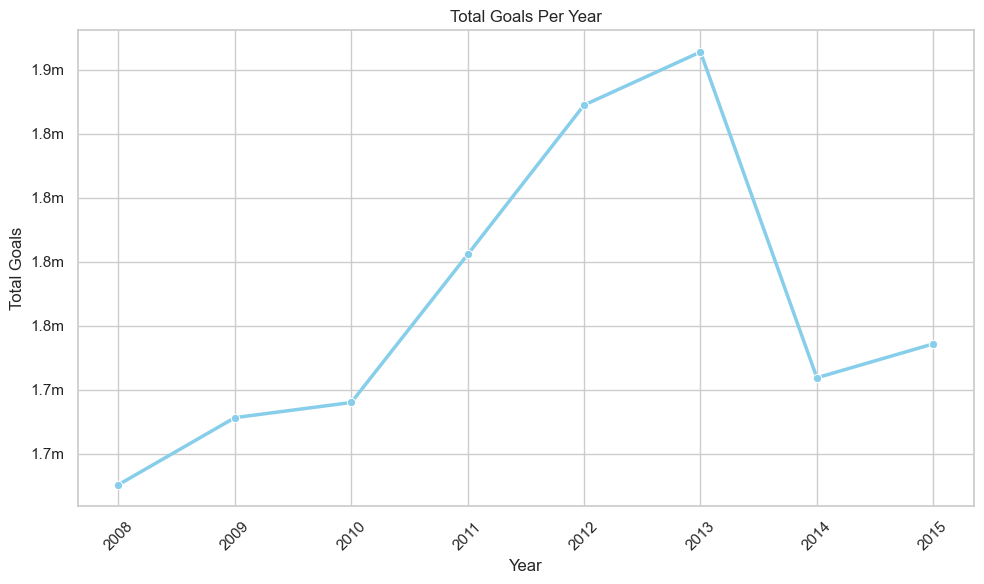

In [8]:
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}m'


goals_per_year = players_goal.groupby('season')['goals_y'].sum().reset_index()


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.lineplot(data=goals_per_year, x='season', y='goals_y', marker='o', color='skyblue', linewidth=2.5)
plt.title('Total Goals Per Year')
plt.xlabel('Year')
plt.ylabel('Total Goals')
plt.xticks(rotation=45)


formatter = FuncFormatter(millions_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


I wanted to understand why there was such a spike in goal count from 2010 onwards.

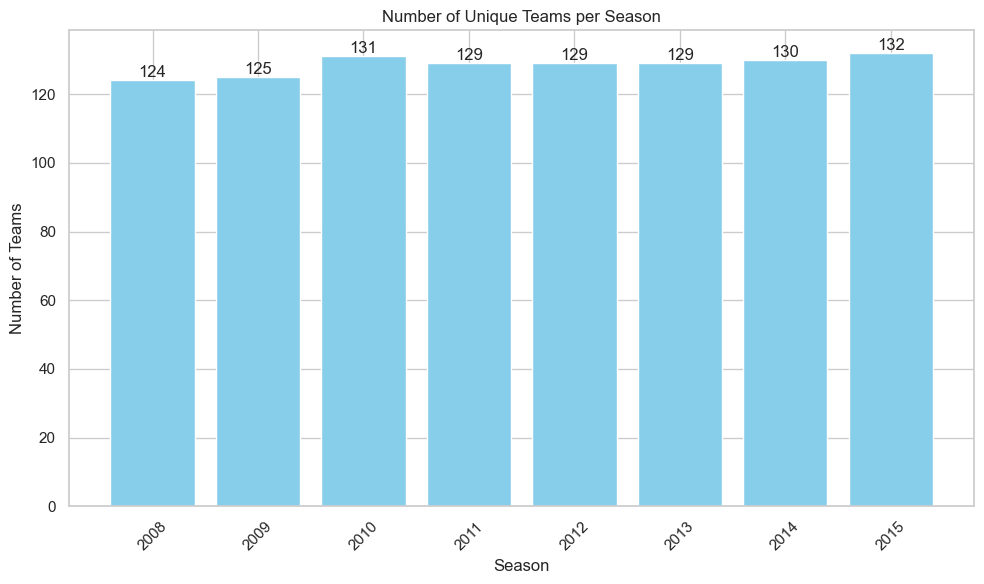

In [9]:
team_counts_per_season = players_goal.groupby('season')['team'].nunique().reset_index()


plt.figure(figsize=(10, 6))
bars = plt.bar(team_counts_per_season['season'], team_counts_per_season['team'], color='skyblue')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.title('Number of Unique Teams per Season')
plt.xlabel('Season')
plt.ylabel('Number of Teams')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Unique teams stays relatively the same. what else coud it be?

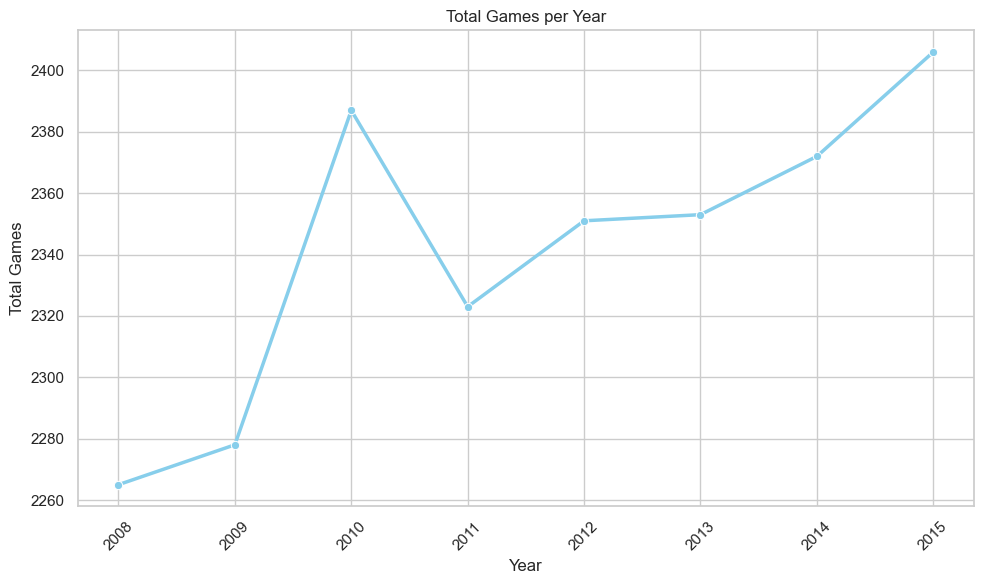

In [10]:
games_per_year = players_goal.groupby('season')['match_api_id'].nunique().reset_index()


plt.figure(figsize=(10, 6))
sns.lineplot(data=games_per_year, x='season', y='match_api_id', marker='o', color='skyblue', linewidth=2.5)
plt.title('Total Games per Year')
plt.xlabel('Year')
plt.ylabel('Total Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ah, mystery solved, more games more goals? More is more afterall.

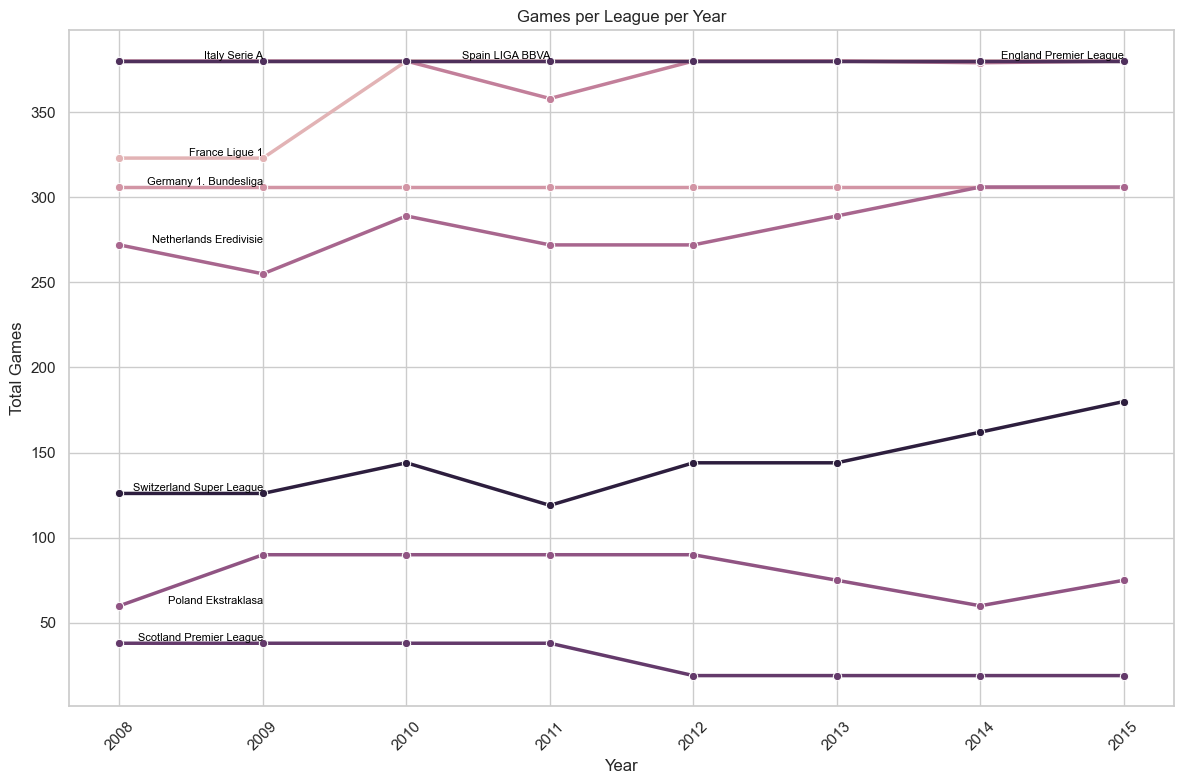

In [11]:

league_labels = {
    21518: 'Spain LIGA BBVA',
    1729: 'England Premier League',
    10257: 'Italy Serie A',
    7809: 'Germany 1. Bundesliga',
    4769: 'France Ligue 1',
    13274: 'Netherlands Eredivisie',
    24558: 'Switzerland Super League',
    19694: 'Scotland Premier League',
    15722: 'Poland Ekstraklasa'
}

games_per_league_per_year = players_goal.groupby(['season', 'league_id'])['match_api_id'].nunique().reset_index()


midpoint_year = games_per_league_per_year['season'].min() + (games_per_league_per_year['season'].max() - games_per_league_per_year['season'].min()) // 2


plt.figure(figsize=(12, 8))
sns.lineplot(data=games_per_league_per_year, x='season', y='match_api_id', hue='league_id', marker='o', linewidth=2.5, legend=False)


prev_y = {}  
for league_id in games_per_league_per_year['league_id'].unique():
    league_data = games_per_league_per_year[games_per_league_per_year['league_id'] == league_id]
    first_row = league_data.iloc[0]  # Get the first row for each league
    league_name = league_labels[league_id]
    
    
    y_pos = first_row['match_api_id']
    if league_name in prev_y:
        y_pos = prev_y[league_name] + 50  # Adjust spacing as needed
    
    
    if league_name == 'Spain LIGA BBVA':
        plt.text(midpoint_year, y_pos, league_name, fontsize=8, color='black', ha='right', va='bottom')
    elif league_name == 'England Premier League':
        plt.text(games_per_league_per_year['season'].max(), y_pos, league_name, fontsize=8, color='black', ha='right', va='bottom')
    else:
        plt.text(first_row['season'] + 1, y_pos, league_name, fontsize=8, color='black', ha='right', va='bottom')
    
    
    prev_y[league_name] = y_pos

plt.title('Games per League per Year')
plt.xlabel('Year')
plt.ylabel('Total Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/Users/mimi/Desktop/PYTHON/TURING/HOME/DA/football_capstone/utilities.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  subtype_counts = subtype_counts.append(subtype_count)
/Users/mimi/Desktop/PYTHON/TURING/HOME/DA/football_capstone/utilities.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  subtype_counts = subtype_counts.append(subtype_count)
/Users/mimi/Desktop/PYTHON/TURING/HOME/DA/football_capstone/utilities.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  subtype_counts = subtype_counts.append(subtype_count)
/Users/mimi/Desktop/PYTHON/TURING/HOME/DA/football_capstone/utilities.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

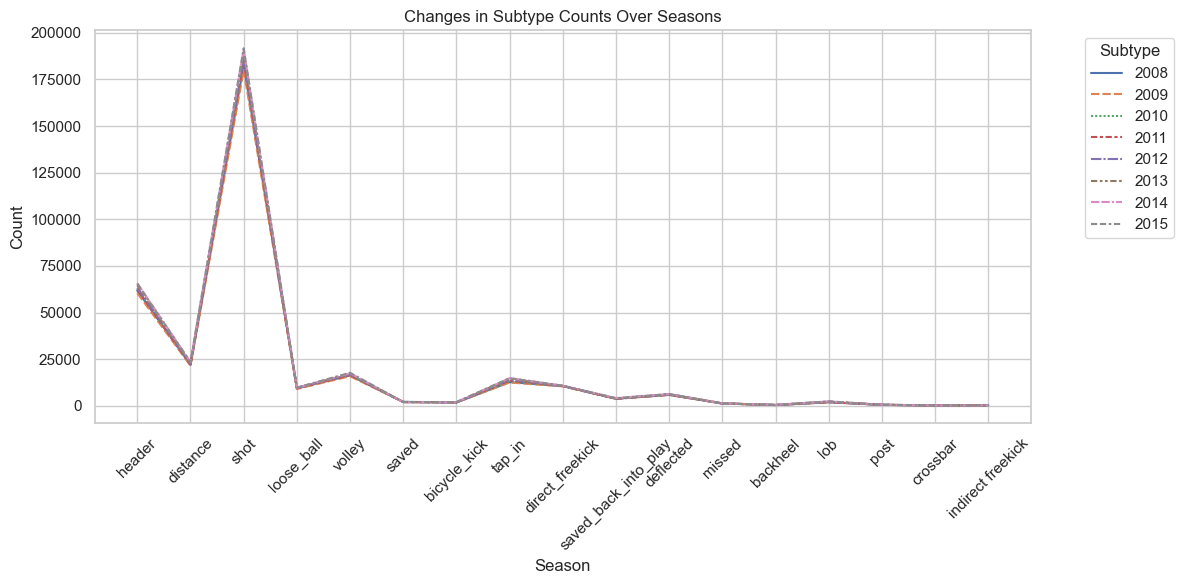

In [12]:



subtype_changes = utilities.track_subtype_changes(players_goal)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=subtype_changes.T)
plt.title('Changes in Subtype Counts Over Seasons')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The subtype that has changed the most over the years is: shot


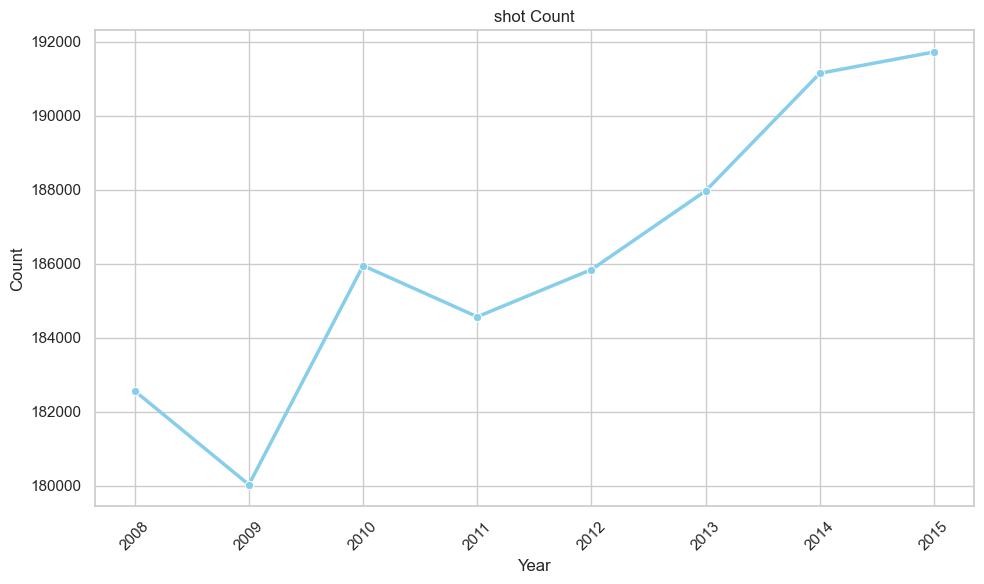

In [17]:
def track_subtype_changes(data):
    subtype_counts = data.groupby(['season', 'subtype']).size().unstack(fill_value=0)
    
    subtype_changes = subtype_counts.diff().abs().sum(axis=0)
    
    most_changed_subtype = subtype_changes.idxmax()
    
    return most_changed_subtype, subtype_changes

def plot_subtype_changes(data, most_changed_subtype):
    most_changed_subtype_data = data[data['subtype'] == most_changed_subtype]
    subtype_counts_per_season = most_changed_subtype_data.groupby('season').size()
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subtype_counts_per_season, marker='o', color='skyblue', linewidth=2.5)
    plt.title(f'{most_changed_subtype} Count')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




most_changed_subtype, subtype_changes = track_subtype_changes(players_goal)
print(f"The subtype that has changed the most over the years is: {most_changed_subtype}")

plot_subtype_changes(players_goal, most_changed_subtype)


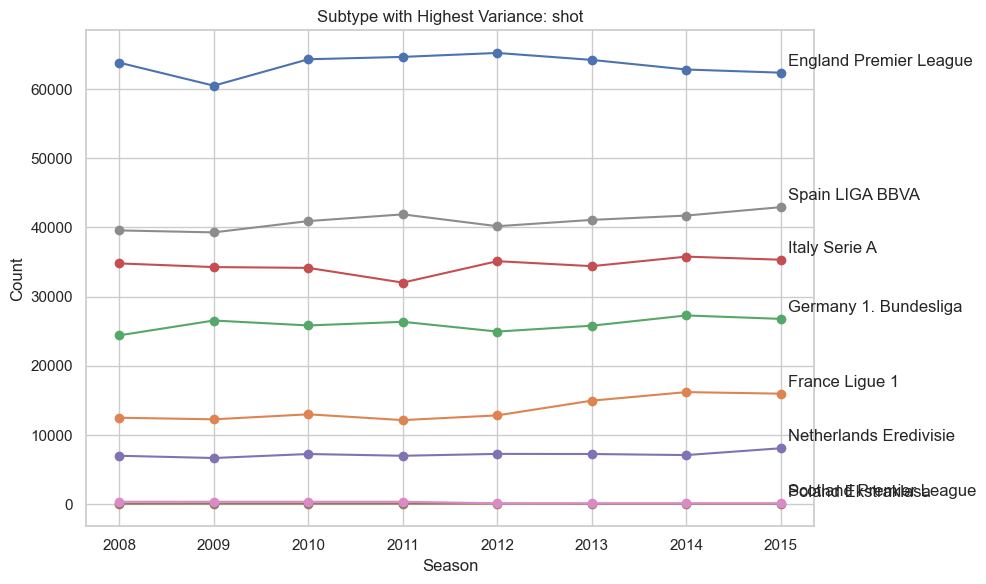

In [ ]:


league_labels = {
    21518: 'Spain LIGA BBVA',
    1729: 'England Premier League',
    10257: 'Italy Serie A',
    7809: 'Germany 1. Bundesliga',
    4769: 'France Ligue 1',
    13274: 'Netherlands Eredivisie',
    24558: 'Switzerland Super League',
    19694: 'Scotland Premier League',
    15722: 'Poland Ekstraklasa'
}

subtype_counts = players_goal.groupby(['league_id', 'season', 'subtype']).size().reset_index(name='count')

subtype_variances = subtype_counts.groupby(['league_id', 'subtype'])['count'].var().reset_index()
max_variance_subtypes = subtype_variances.loc[subtype_variances.groupby('league_id')['count'].idxmax()]

selected_data = subtype_counts.merge(max_variance_subtypes[['league_id', 'subtype']], on=['league_id', 'subtype'])

plt.figure(figsize=(10, 6))
for league_id, league_data in selected_data.groupby('league_id'):
    league_name = league_labels.get(league_id, str(league_id))
    plt.plot(league_data['season'], league_data['count'], marker='o', label=league_name)

for league_id, league_data in selected_data.groupby('league_id'):
    league_name = league_labels.get(league_id, str(league_id))
    last_season = league_data['season'].iloc[-1]
    last_count = league_data['count'].iloc[-1]
    plt.annotate(league_name, (last_season, last_count), textcoords="offset points", xytext=(5, 5), ha='left')

subtype = max_variance_subtypes['subtype'].iloc[0]
plt.title(f"Subtype with Highest Variance: {subtype}")

plt.xlabel('Season')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression

In [ ]:
bets_regression = match_df[match_df['league_id'] == 1729][['match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal','B365H','B365D','B365A','BWH','BWD','BWA', 'IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA' ]]
bets_regression["winning_team"] = bets_regression.apply(utilities.assign_victory, axis = 1)
bets_regression.drop(bets_regression[bets_regression["winning_team"] == '2'].index, inplace=True)
bets_regression.drop(columns=['home_team_goal', 'away_team_goal', 'away_team_api_id', 'home_team_api_id', 'match_api_id'], inplace=True)
bets_regression.fillna(0, inplace=True)
bets_regression['winning_team'] = bets_regression['winning_team'].astype(int)

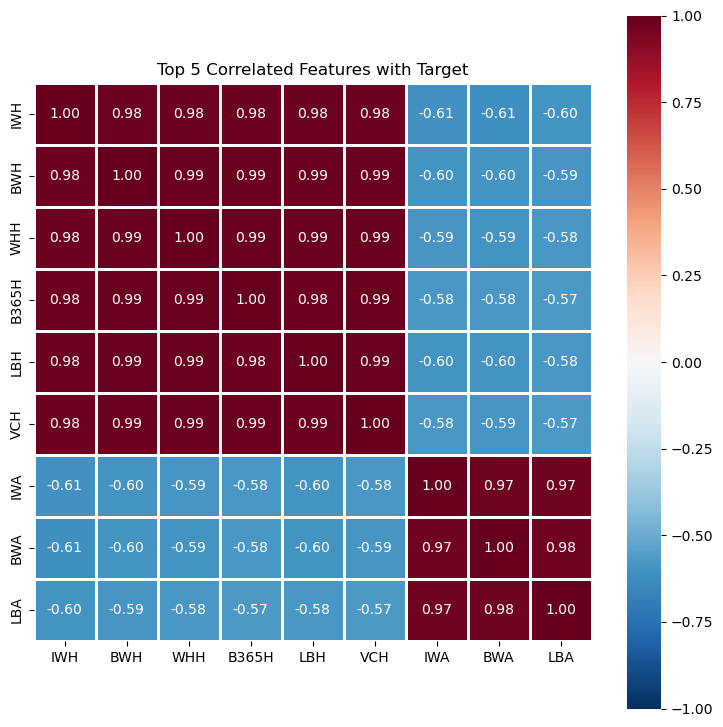

In [ ]:



corr_matrix = bets_regression.corr()


corr_with_target = corr_matrix['winning_team'].abs()


top_correlated_features = corr_with_target.sort_values(ascending=False).head(10)[1:]  


most_correlated = corr_matrix.loc[top_correlated_features.index, top_correlated_features.index]


plt.figure(figsize=(9, 9))
plt.title("Top 5 Correlated Features with Target")
ax = sns.heatmap(
    most_correlated,
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)
plt.show()


In [ ]:



X = bets_regression.drop(columns=['winning_team'])  
y = bets_regression['winning_team']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train, y_train)




y_pred = logisticRegr.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.6814159292035398
Precision: 0.7006802721088435
Recall: 0.6398553635998393
F1 Score: 0.6331168831168832
Confusion Matrix:
 [[236  26]
 [118  72]]
Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.90      0.77       262
           3       0.73      0.38      0.50       190

    accuracy                           0.68       452
   macro avg       0.70      0.64      0.63       452
weighted avg       0.70      0.68      0.65       452



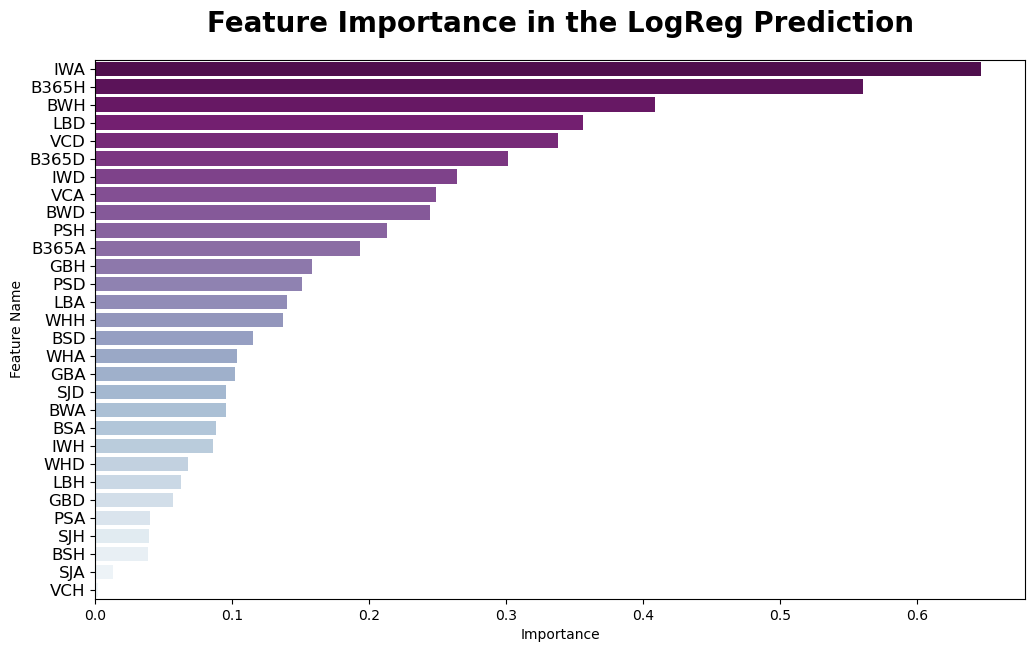

In [ ]:
coefficients = logisticRegr.coef_[0]

imp_df = pd.DataFrame({"Feature Name":X_train.columns,
                       "Importance":np.abs(coefficients)})
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="BuPu_r")
plt.title("Feature Importance in the LogReg Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

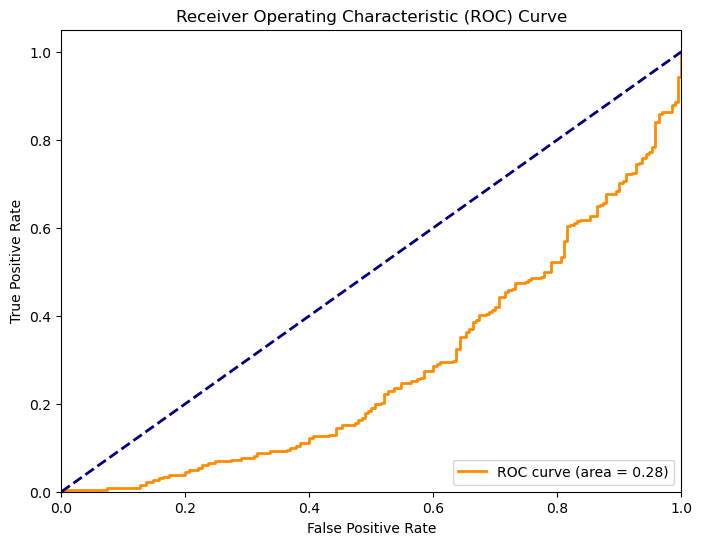

In [ ]:

pos_label = 1  


y_scores = logisticRegr.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=pos_label)


roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


the model is not performing well in correctly identifying the positive class (winning team) while also minimizing false positives (incorrectly predicting a winning team). This could indicate that the model is not capturing important patterns or relationships in the data, or that it may be biased towards one class.

As we can see, this did not work.